  
# Keystroke analysis


#### IN791 presentation
#### Sohhom Bandyopadhyay (1551001)

#### Supervised By:   Prof Krishna Prasad Miyapuram

### 27 Nov 2018


### Name typing

#### Task
- Each participant typed their name 20 times
- Backspace and other edits were not allowed

#### Dendrogram from hierarchical clustering of name data
- Hierarchical clustering to reveal the patterns

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hc
from pyclustering.cluster.xmeans import xmeans
from chunk_utils import *
data_dir = './data/names'
image_dir = './images/'

In [2]:
# basic init
filenames = list(filter(lambda x: x.endswith('.kdt'), os.listdir(data_dir)))

# DO NOT CHANGE THE FIGSIZE
matplotlib.rcParams['figure.figsize'] = 15, 10

font = {'size': 16}
matplotlib.rc('font', **font)
%load_ext autoreload
%autoreload 2

In [3]:
with open(data_dir+'//'+filenames[2], 'r') as fh:
    mydata = fh.read()
typedname, rawkd = mydata.split('\n')
tt = typedname.replace(' ','_')
keypairs = list(map(lambda x: x[0]+x[1], zip(tt, tt[1:])))


raw_delays = kdata2delaysOLD(typedname, rawkd)
cumulative_delays = np.array([np.cumsum(delay1) for delay1 in raw_delays])


raw_delays = raw_delays.transpose()
cumulative_delays = cumulative_delays.transpose()

len(typedname), typedname, raw_delays.shape, cumulative_delays.shape

(20, 'sohhom bandyopadhyay', (19, 20), (19, 20))

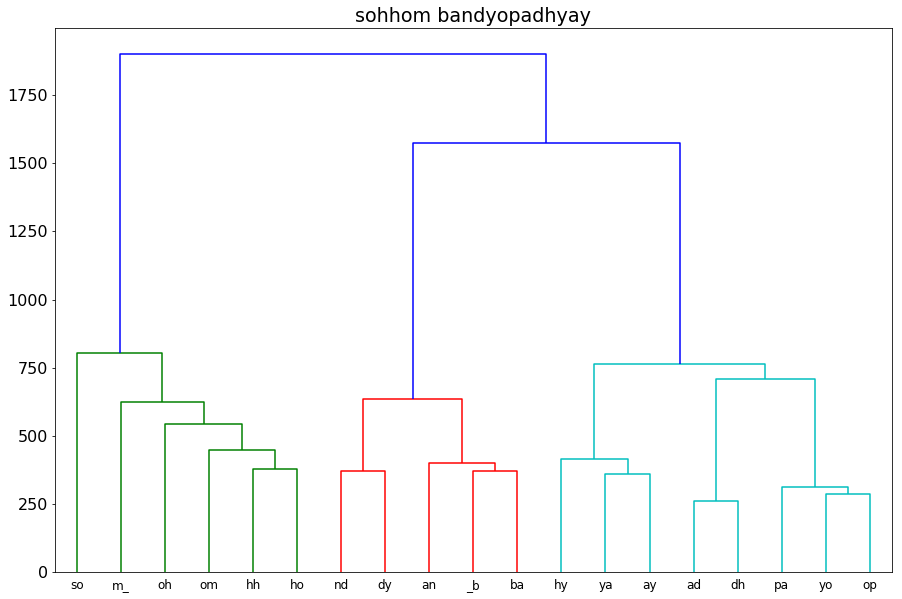

In [4]:
plt.title(typedname)
dn = hc.dendrogram(hc.linkage(cumulative_delays,'single'), labels=keypairs)

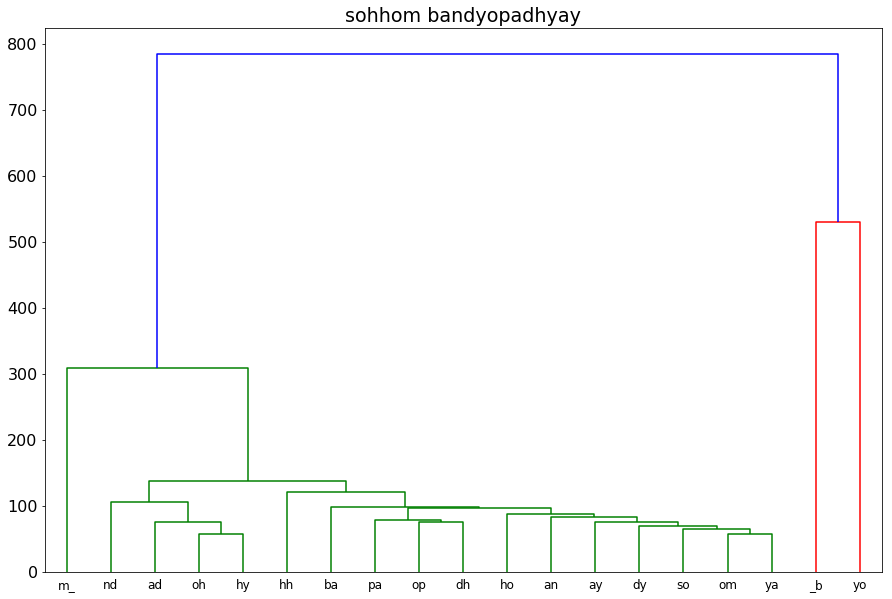

In [5]:
plt.title(typedname)
dn = hc.dendrogram(hc.linkage(raw_delays,'single'), labels=keypairs)

In [6]:
ypos = 0.01
ydelta = 0.045

(0.0, 1.0, 0.0, 1.0)

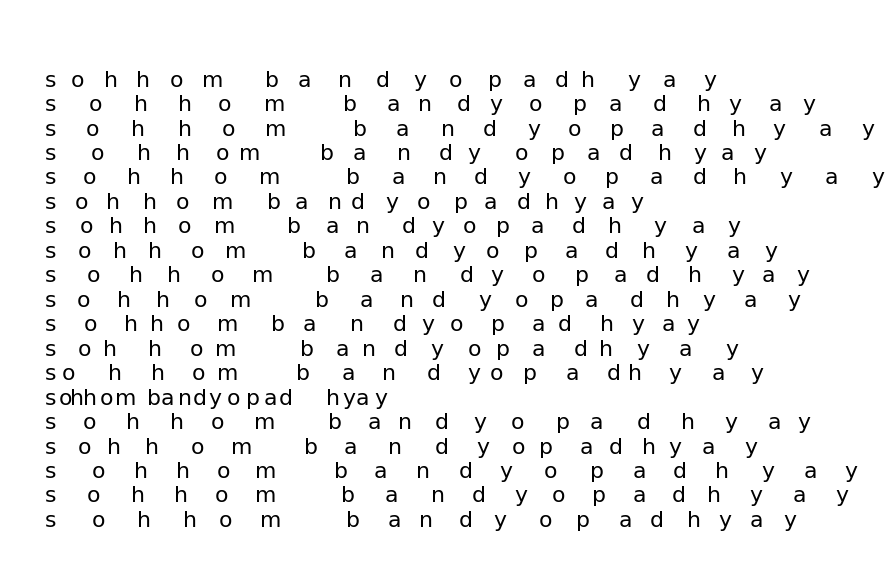

In [7]:
# plot delays as spatial gaps
for dd in raw_delays:
    xposvector = get_xpos_from_delays(dd, space_min = 0.006, max_delta_spacing=0.05)
    for char, xpos in zip(typedname, xposvector):
        plt.text(xpos, ypos + ydelta, char, fontsize=22)
    ypos += ydelta
plt.axis('off')